# Exercises

```{contents}
:local:
```

In [ ]:
from __future__ import annotations

import os
import random
import string
import sys
from functools import lru_cache
from pathlib import Path
from typing import List, Any

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng


def find_root_dir(current_path: Path | None = None, marker: str = '.git') -> Path | None:
    """
    Find the root directory by searching for a directory or file that serves as a
    marker.

    Parameters
    ----------
    current_path : Path | None
        The starting path to search from. If None, the current working directory
        `Path.cwd()` is used.
    marker : str
        The name of the file or directory that signifies the root.

    Returns
    -------
    Path | None
        The path to the root directory. Returns None if the marker is not found.
    """
    if not current_path:
        current_path = Path.cwd()
    current_path = current_path.resolve()
    for parent in [current_path, *current_path.parents]:
        if (parent / marker).exists():
            return parent
    return None

root_dir = find_root_dir(marker='omnivault')

if root_dir is not None:
    sys.path.append(str(root_dir))
    from omnivault.utils.visualization.style import use_svg_display
    from omnivault.utils.reproducibility.seed import seed_all
else:
    raise ImportError("Root directory not found.")

use_svg_display()
seed_all()

- Consider one day to code up random generators like Uniform Distribution from scratch:
- https://github.com/neerajkumarvaid/Data-Science-From-Scratch-Python/blob/master/probability.py
- https://towardsdatascience.com/how-to-generate-random-variables-from-scratch-no-library-used-4b71eb3c8dc7

## Question 6

In [5]:
def f(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    return np.divide(1, np.multiply(2 * np.sqrt(3), np.pi)) * np.exp(
        np.multiply(
            np.divide(-1, 6),
            (x ** 2 - 2 * x * y - 2 * x + 4 * y ** 2 + 2 * y + 1),
        )
    )

Create meshgrids such that we enumerate cases of the range $[-3, 3] \times [-3, 3]$ for the values that $X$ and $Y$ can take on. Correspondingly, set $Z = f(X, Y)$ such that we have constant values for the set of values we got from the meshgrid.

As an example:

- When $X = -3, Y = 3$, we have $Z = f(X, Y) = 2.8986519194402697e-07$. This is one contour line in the 2d space, but why it looks like a curvature (circle)? This suggests that when keeping $Z$ to be the constant of $2.8986519194402697e-07$, there are many different set of $(X, Y)$ that gives this value!

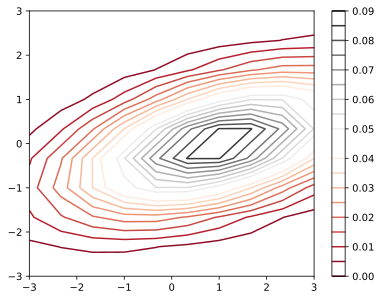

In [6]:
X = np.linspace(-3, 3, 10)
Y = np.linspace(-3, 3, 10)
X, Y = np.meshgrid(X, Y)
Z = f(X, Y)
plt.contour(X, Y, Z, 20, cmap='RdGy')
plt.colorbar();

## Question 9

In [7]:
# @lru_cache
def calc_vowel_consonant_prob(
    num_simulations: int,
    letters: List[str],
    vowels: List[str],
    consonants: List[str],
    *args,
    **kwargs,
) -> float:
    """A collection of 26 English letters, a-z, is mixed in a jar. Two letters are drawn at random,
    one after the other without replacement. What is the probability of drawing a vowel (a,e,i,o,u)
    and a consonant in either order?

    Args:
        num_simulations (int): Number of simulations to run.
        letters (List[str]): List of letters.
        vowels (List[str]): List of vowels.
        consonants (List[str]): List of consonants.

    Returns:
        (float): The probability of drawing a vowel and a consonant in either order.
    """
    count = 0
    rng = default_rng()

    letters = np.asarray(letters)

    for _ in range(num_simulations):
        sample_2_letters_without_replacement = rng.choice(*args, **kwargs)
        chosen_letters = letters[sample_2_letters_without_replacement]
        if not (
            set(chosen_letters).issubset(vowels)
            or set(chosen_letters).issubset(consonants)
        ):
            count += 1

    return count / num_simulations

In [8]:
all_letters = list(string.ascii_lowercase)
vowels = ["a", "e", "i", "o", "u"]
consonants = list(set(all_letters) - set(vowels))

num_simulations = 1000000
calc_vowel_consonant_prob(num_simulations, all_letters, vowels, consonants, a=26, size=2, replace=False)

0.323293

- `sample_2_letters_without_replacement = rng.choice(a = 26, size = 2, replace=False)`: This is equivalent to `random.sample(range(26), 2)` which if we set the parameters correctly, means we will sample index 0 to 25 twice, without replacement. For example, the sampled index is in a form of a array of size 2: `[1, 4]` which corresponds to the letters `[b, e]`.
    - Note in particular this **sampling** is a using a **uniform distribution** where each letter has $\frac{1}{26}$ chance of getting selected in the first sample.
- `chosen_letters = np.asarray(all_letters)[sample_2_letters_without_replacement]`: This is just subsetting the index from the `all_letters`. Since `all_letters` is a list which enumerates the alphabets in order, it suffices for us to just subset the array directly to get the chosen letters.
- `if not (set(chosen_letters).issubset(vowels) or set(chosen_letters).issubset(consonant)): count += 1`: If our `chosen_letters` is neither a subset of the vowels or the consonant, then this means that it fulfills our condition, (i.e. one consonant and one vowel, we don't care order since the question said either order). If condition fulfilled, `count` adds 1.
- Lastly, calculate the probability by dividing the `count` by the `num_simulations` to get the frequency (i.e the probability). Indeed with enough simulations, the probability converges to the theoretical answer of $0.3230...$. 

## Question 10: Birthday Paradox

Settings:

- 50 people
    - Assume each person has a $\frac{1}{365}$ probability to be assigned a birthday. In other words, the person's birthday should come from a uniform distribution from 1 to 365.
    - So simple modelling just allows us to draw numbers for these 50 people from $[1, 365]$ and whenever the number is same we say they are of the same birthday.
- Want to find probability (frequency) of at least 2 people have same birthday.
    - Note that in your code one should also consider any number $>=2$.


In [9]:
rng = np.random.default_rng()
num_possible_birthdays = 365
num_people = 50
num_simulations = 1000

In [10]:
def containsDuplicate(nums: List[int]) -> bool:
    """Check if a list contains duplicate elements.

    Args:
        nums (List[int]): List of integers.

    Returns:
        bool: Boolean value to indicate if the list contains duplicate elements.
    """
    dup_dict = {}

    for _, num in enumerate(nums):
        if num not in dup_dict:
            dup_dict[num] = 0
        else:
            return True
    return False

In [11]:
def generate_one_random_birthday(num_possible_birthdays: int = 365) -> int:
    """Generate one random birthday from 1 to num_possible_birthdays.

    Samples 1 integer from 1 to 365 from a uniform distribution.

    Args:
        num_possible_birthdays (int): The number of possible birthdays. Defaults to 365.

    Returns:
        birthday (int): The random birthday in integer.
    """
    # Return random integers from the "discrete uniform" distribution of the specified dtype. If high is None (the default), then results are from 0 to low.
    birthday = rng.integers(num_possible_birthdays, size=None) # size=None to return integer instead of array of ints
    return birthday

In [12]:
def generate_k_birthdays(
    num_people: int, *args: Any, **kwargs: Any
) -> List[int]:
    """Generates all possible birthdays for a given number of people sampled
    from a uniform distribution.

    Example:
        If there are 3 people, the possible birthdays can be understood to be sampled from a uniform distribution
        of 1 to 365 inclusive with replacement.
        >>> generate_k_birthdays(3, 365)

    Args:
        num_people (int): The number of people in the group.
        num_possible_birthdays (int, optional): Number of possible birthdays. Defaults to 365.

    Returns:
        birthdays (List[int]): A list of birthdays.

    """

    birthdays = [
        generate_one_random_birthday(*args, **kwargs)
        for _ in range(num_people)
    ]
    return birthdays

In [13]:
def calculate_same_birthday_probability(
    num_simulations: int, *args: Any, **kwargs: Any
) -> float:
    """Calculates the probability of the Birthday Paradox Problem.

    Args:
        num_simulations (int, optional): The number of simulations to run.

    Returns:
        probability (float): The probability of the Birthday Paradox.
    """
    count = 0
    for _ in range(num_simulations):
        birthdays = generate_k_birthdays(*args, **kwargs)
        if containsDuplicate(birthdays):
            count += 1

    probability = count / num_simulations
    return probability

In [14]:
calculate_same_birthday_probability(num_simulations=10000, num_people=50, num_possible_birthdays=365)

0.9692

We go through one loop of the simulation to understand the code:

- `birthdays = default_rng().choice(a=num_possible_birthdays, size=num_people, replace=True)`: what this does is two folds,
    - Samples 1 integer from 1 to 365 from a uniform distribution. (i.e. 1 to num_possible_birthdays)
    - Repeat the sampling of 1 integer 50 times. (i.e. num_people=50)
    - In short, it returns an array of 50 elements, each element is sampled uniformly from 1 to 365 inclusive.
- `if has_duplicates(birthdays)` checks whether the array has duplicates (i.e. akin to checking if 2 or more people has the same birthdays).
    - If `True`, `count +=1`.
- Finally, the probability is the number of `count` divided by the total number of simulations. It should converge to around $0.97$.
- One should realize by now probability in most parts, is just the frequency of "occurring" over the total number of "events".

In [15]:
def calculate_same_birthday_probability_rng_choice(
    num_simulations: int,
    num_people: int = 50,
    num_possible_birthdays: int = 365,
    replace: bool = True,
) -> float:
    """Calculates the probability of the Birthday Paradox Problem.

    Args:
        num_simulations (int, optional): The number of simulations to run.
        num_people (int, optional): The number of people in the simulation.
        num_possible_birthdays (int, optional): The number of possible birthdays.
        replace (bool, optional): Whether or not to sample with replacement.

    Returns:
        probability (float): The probability of the Birthday Paradox.
    """
    count = 0
    for _ in range(num_simulations):
        birthdays = default_rng().choice(a=num_possible_birthdays, size=num_people, replace=replace)
        if containsDuplicate(birthdays):
            count += 1

    probability = count / num_simulations
    return probability

In [16]:
calculate_same_birthday_probability_rng_choice(num_simulations=10000, num_people=50, num_possible_birthdays=365, replace=True)

0.9734

The below code is not mine and is taken from [here](https://www.probabilisticworld.com/birthday-problem-python-simulation/). For my reference to see if I coded correctly.

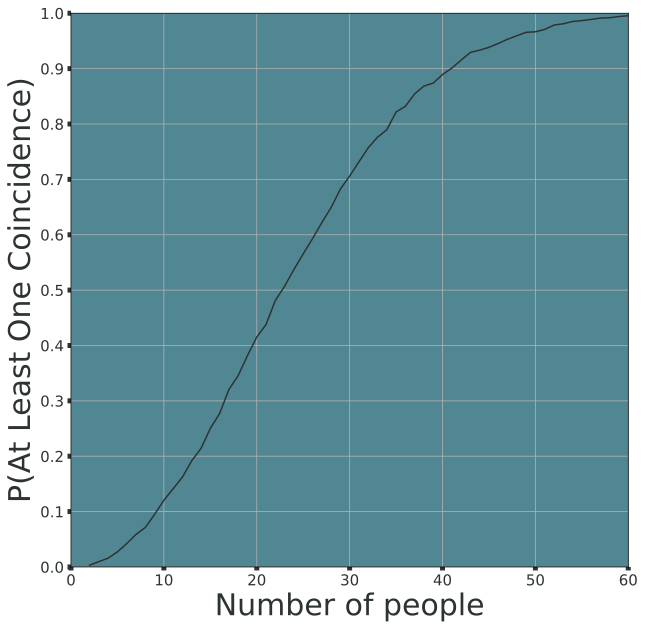

In [17]:
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns

MIN_NUM_PEOPLE = 2
MAX_NUM_PEOPLE = 60
NUM_POSSIBLE_BIRTHDAYS = 365
NUM_TRIALS = 10000

def generate_random_birthday():
    birthday = randint(1, NUM_POSSIBLE_BIRTHDAYS)
    return birthday

def generate_k_birthdays(k):
    birthdays = [generate_random_birthday() for _ in range(k)]
    return birthdays

def aloc(birthdays):
    unique_birthdays = set(birthdays)

    num_birthdays = len(birthdays)
    num_unique_birthdays = len(unique_birthdays)
    has_coincidence = (num_birthdays != num_unique_birthdays)

    return has_coincidence

def estimate_p_aloc(k):
    num_aloc = 0
    for _ in range(NUM_TRIALS):
        birthdays = generate_k_birthdays(k)
        has_coincidence = aloc(birthdays)
        if has_coincidence:
            num_aloc += 1

    p_aloc = num_aloc / NUM_TRIALS
    return p_aloc

def estimate_p_aloc_for_range(ks):
    k_probabilities = []

    for k in ks:
        p_aloc = estimate_p_aloc(k)
        k_probabilities.append(p_aloc)

    return k_probabilities

ks = range(MIN_NUM_PEOPLE, MAX_NUM_PEOPLE + 1)
k_probabilities = estimate_p_aloc_for_range(ks)

fig, ax = plt.subplots(figsize=(10, 10), dpi=49)
ax.set_facecolor('#518792')
ax.xaxis.set_tick_params(width=5, color='#2d3233')
ax.yaxis.set_tick_params(width=5, color='#2d3233')

sns.lineplot(x=ks, y=k_probabilities, color='#2d3233')

plt.xticks(fontsize=15, color='#2d3233')
y_range = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
plt.yticks(y_range, fontsize=15, color='#2d3233')
plt.grid()
plt.xlim([0, 60])
plt.ylim([0, 1])
plt.xlabel('Number of people', fontsize=30, color='#2d3233')
plt.ylabel('P(At Least One Coincidence)', fontsize=30, color='#2d3233')

plt.show()